## VGG网络
虽然AlexNet证明深层神经网络卓有成效，但它没有提供一个通用的模板来指导后续的研究人员设计新的网络。 在下面的几个章节中，我们将介绍一些常用于设计深层神经网络的启发式概念。

与芯片设计中工程师从放置晶体管到逻辑元件再到逻辑块的过程类似，神经网络架构的设计也逐渐变得更加抽象。研究人员开始从单个神经元的角度思考问题，发展到整个层，现在又转向块，重复层的模式。

使用块的想法首先出现在牛津大学的视觉几何组（visual geometry group）的VGG网络中。通过使用循环和子程序，可以很容易地在任何现代深度学习框架的代码中实现这些重复的架构。  
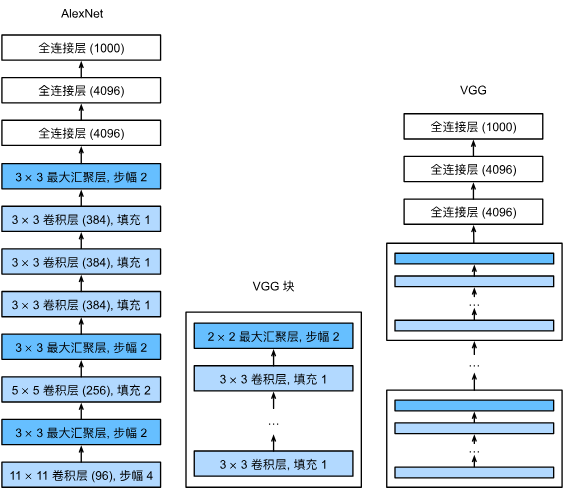

In [1]:
#7.2.1 VGG块
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [2]:
#7.2.2 VGG Net
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [3]:
def vgg11(onv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg11(conv_arch)

In [4]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [5]:
#7.2.3. 训练模型
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg11(small_conv_arch)

loss 0.100, train acc 0.963, test acc 0.921
144.0 examples/sec on cuda:0


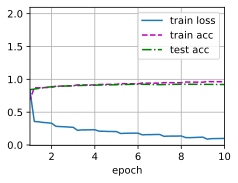

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

1. 打印层的尺寸时，我们只看到8个结果，而不是11个结果。剩余的3层信息去哪了？
    - 剩余的3层是全连接层，它们的输出形状是固定的，因此在打印时没有显示。

2. 与AlexNet相比，VGG的计算要慢得多，而且它还需要更多的显存。分析出现这种情况的原因。
    - VGG使用了更多的卷积层和参数，这导致计算量和显存需求增加。特别是VGG的卷积层使用了较小的卷积核（$3 \times 3$），这增加了计算复杂度。

3. 尝试将Fashion-MNIST数据集图像的高度和宽度从224改为96。这对实验有什么影响？
    - 将图像尺寸改为96会减少计算量和显存需求，但也可能导致模型性能下降，因为输入图像包含的信息减少了。

4. 请参考VGG论文 ([Simonyan and Zisserman, 2014](https://arxiv.org/abs/1409.1556))中的表1构建其他常见模型，如VGG-16或VGG-19。
